In [1]:
## for WLFH with optimizing carrier wave
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
from FresnelPropagation_as import FresnelPropagation_as
from WignerLFH import WignerLFH
from myfft2 import myfft2
import time
import torch.nn as nn
import torch.nn.functional as F

NxFile, NyFile = 300, 200
NuFile, NvFile = 40, 40
dxFile, dyFile = 3.74e-6, 3.74e-6
iwv = 520e-9 
dxH, dyH = dxFile, dxFile
Nu, Nv = NuFile, NvFile
du, dv = 1/Nu/dxH, 1/Nv/dyH
dTheta = du*iwv

NxL, NyL = 300, 200
M = 10
dxL, dyL = dxFile*M, dxFile*M
LH = NxL*dxL
dtheta = dv*iwv
z = [-dyL/dtheta, -2/3*(-dyL/dtheta)]
bufferX = (Nu//2)+1
bufferY = (Nv//2)+1

LFH = WignerLFH()

In [2]:
def modelGradients(weight, dxH, z, iwv):

    lambda_val = iwv    
    W_SSB = myfft2(weight)
    W_SSB[1000:,:] = 0 #일단 임의로 1000쯤으로
    W_SSB_R = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(W_SSB)))
    output = torch.zeros(len(z)*2,1,NyL*M, NxL*M)
    output = output.cuda()
    
    for i in range(len(z)):
        rec1 = FresnelPropagation_as(W_SSB_R, dxH, dxH, z[i], lambda_val)
        rec = abs(rec1)
        output[i,:,:] = torch.abs(rec[bufferY:-bufferY,bufferX:-bufferX])

    return output

In [3]:
# GPU 할당
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device: {}".format(device, torch.cuda.get_device_name(0)))

# initialize W
W_img = torch.randn(NyL*M+bufferY*2, NxL*M+bufferX*2)
W_rnd = torch.exp(1j*W_img) * torch.randn(NyL*M+bufferY*2, NxL*M+bufferX*2)
W_SSB = myfft2(W_rnd)
W_SSB[1000:,:] = 0 #일단 임의로 1000쯤으로

W_ift = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(W_SSB)))
W = W_ift

target = torch.ones(len(z),NyL*M, NxL*M).cuda()

W = W.cuda()
W.requires_grad_(True)
target = target.cuda()

Using cuda device: NVIDIA GeForce RTX 4090


d:\python\ksenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\python\ksenv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 2000, 3000])) that is different to the input size (torch.Size([2, 1, 2000, 3000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iteration: 1, loss 0.2625744938850403, time: 8.82874584197998
iteration: 2, loss 0.22027233242988586, time: 8.99686861038208
iteration: 3, loss 0.18559753894805908, time: 9.178970575332642
iteration: 4, loss 0.15954889357089996, time: 9.352057456970215
iteration: 5, loss 0.14178873598575592, time: 9.527587652206421
iteration: 6, loss 0.13032348453998566, time: 9.699706315994263
iteration: 7, loss 0.12204045057296753, time: 9.872827768325806
iteration: 8, loss 0.11429423093795776, time: 10.048723459243774
iteration: 9, loss 0.10602887719869614, time: 10.22580885887146
iteration: 10, loss 0.09750266373157501, time: 10.403933763504028
iteration: 11, loss 0.08948632329702377, time: 10.584044933319092
iteration: 12, loss 0.08267585933208466, time: 10.763565063476562
iteration: 13, loss 0.07741664350032806, time: 10.940669059753418
iteration: 14, loss 0.07365082204341888, time: 11.117767333984375
iteration: 15, loss 0.07100927084684372, time: 11.292301893234253
iteration: 16, loss 0.06898304

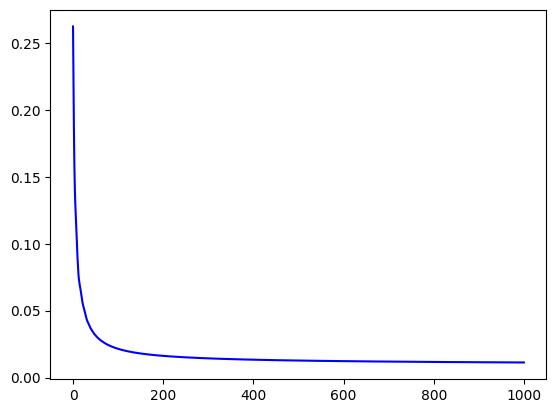

In [4]:
# Training parameters
numIterations =1000
learningRate = 0.5e-1

s1 = torch.tensor(1.0).requires_grad_(True)
s2 = torch.tensor(1.0).requires_grad_(True)
optimizer = torch.optim.Adam([{'params': [W, s1,s2]}] , lr=  learningRate)
loss_fn = nn.MSELoss(reduction='mean')
tic = time.time()
fig, ax = plt.subplots()
x = []
y = []

for iter in range(numIterations+1):
    optimizer.zero_grad()
    recs = modelGradients(W, dxH, z,iwv)
    rec1= s1*recs[0,:,:]
    rec2 = s2*recs[1,:,:]
    rec = torch.stack([rec1,rec2],dim=0)
    loss = loss_fn(rec,target)
    loss.backward()
    optimizer.step()
    toc = time.time()
    print('iteration: {}, loss {}, time: {}'.format(iter+1,loss,(toc-tic))) 
    x.append(iter)
    y.append(loss.cpu().detach().numpy())
plt.plot(x, y, 'b')
plt.show()
del x
del y

# torch.save(W, './weight_LF/weight_20231213_ks_iter' + str(iter)) # for save


In [6]:
# W = torch.load('./weight_LF/weight_20231213_ks_iter1000')
W = W.cpu().detach()
lightField = torch.zeros([NyL, NxL, Nv, Nu])

offsetX = (NxL - NxFile) // 2
offsetY = (NyL - NyFile) // 2

#load light field
for idxU in range(1, NuFile+1):
    for idxV in range(1, NvFile+1):
        temp = np.zeros((NyL, NxL))
        idxFile = idxU + (idxV-1)*NuFile
        temp[offsetY:(offsetY+NyFile), offsetX:(offsetX+NxFile)] = np.array(Image.open(f'.\Socket/sockets_jhpark_{idxFile:04d}.png').convert('L'))
        temp = torch.as_tensor(temp)
        lightField[:, :, idxV-1, idxU-1] = temp / temp.max()

FTlightField = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(lightField)))
# FTlightField = FTlightField.cuda()

hologram = LFH.LFtoH(FTlightField, W, NxL,NyL, Nu, dxL, dxH)

# match with frequency response of hologram
FT_H = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(hologram)))
FT_H[1000:,:]=0
Filtered_H = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(FT_H)))


Processing time for synthesize hologram 162.006395


tensor(0.) tensor(1.)


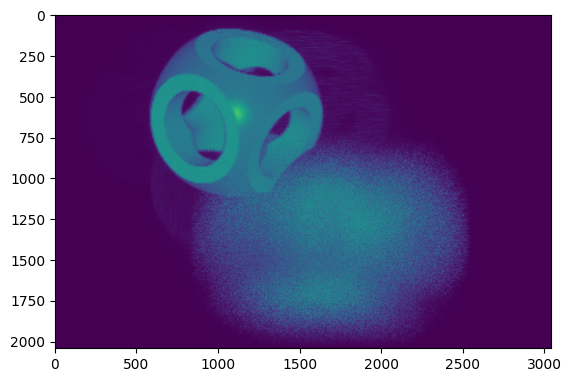

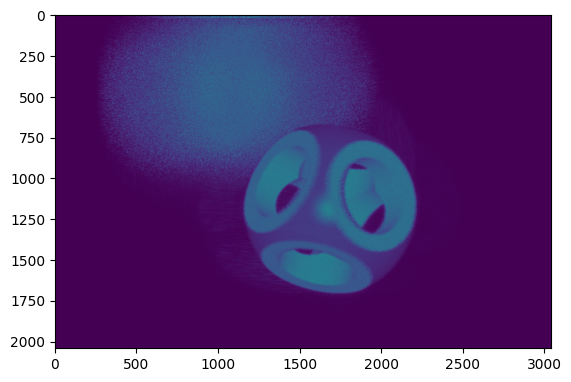

In [7]:
Tosave_SSB_H = torch.real(Filtered_H)-torch.min(torch.real(Filtered_H))
# Tosave_SSB_H = torch.real(Filtered_H)
Tosave_SSB_H = Tosave_SSB_H/torch.max(Tosave_SSB_H)
print(torch.min(Tosave_SSB_H),torch.max(Tosave_SSB_H))
save_SSB_H = Tosave_SSB_H.cpu().detach().numpy()
save_H = np.uint8(save_SSB_H*255)
save_im = Image.fromarray(save_H)
# save_im.save('Real_WLFH_proposed_20231214.jpg')

for d in z:
    rec = FresnelPropagation_as(Filtered_H, dxFile, dyFile, d, iwv)
    plt.figure()
    plt.imshow(abs(rec).cpu().detach().numpy())
    plt.show()
    rec /= torch.max(torch.abs(rec))
    rec_np = torch.abs(rec).cpu().detach().numpy()
    rec_int = np.uint8(rec_np*255)
    im = Image.fromarray(rec_int)

    # im.save('WLFH_rec_layers_{}.jpg'.format(d))